In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2
import matplotlib.pyplot as plt

2024-04-16 07:31:27.287805: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-16 07:31:27.287853: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-16 07:31:27.289570: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-16 07:31:27.534592: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-16 07:31:34.132036: W tensorflow/c

In [2]:
# Load your pre-trained model
model_path = "/global/D1/homes/jayao/XAI-Based-ECG-Diagnostics-main/model/ST-CNN-5_lead7new.h5"
model = keras.models.load_model(model_path)


2024-04-16 07:31:49.773958: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1682 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:5e:00.0, compute capability: 7.5


In [3]:
# Load and preprocess an example ECG signal for visualization
import wfdb
import numpy as np

def load_raw_data(filename, sampling_rate, path):
    if sampling_rate == 100:
        data, meta = wfdb.rdsamp(path + filename + "_lr")
    else:
        data, meta = wfdb.rdsamp(path + filename + "_hr")
    return data


# Example usage
# filename_to_load = "21196"  # ST/T change
# filename_to_load = "02696"  # Hypertrophy
# filename_to_load = "03333"  # Normal ECG
# filename_to_load = "00040"  # Normal ECG
# filename_to_load = "03123"  # CD
# filename_to_load = "03196"  # Normal ECG overleaf
# filename_to_load = "03354"  # MI overleaf
# filename_to_load = "03482"  # MI use this
# filename_to_load = "03204"  # STTC use this
filename_to_load = "01990"  # CD use this

sampling_rate = 100
# path = "/global/D1/homes/jayao/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2/ptbxl/records100/02000/"
# path = "/global/D1/homes/jayao/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2/ptbxl/records100/21000/"
# path = "/global/D1/homes/jayao/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2/ptbxl/records100/03000/"
path = "/global/D1/homes/jayao/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2/ptbxl/records100/01000/"

input_example = load_raw_data(filename_to_load, sampling_rate, path)


In [4]:
input_example.shape

(1000, 12)

In [5]:
import numpy as np

# Extracting values from the second column (Lead 27)
input_example = input_example[:, 6]


In [6]:
input_example.shape

(1000,)

In [7]:
input_example = input_example.reshape(1, 1, 1000, 1)   # Add another channel

In [8]:
input_example.shape

(1, 1, 1000, 1)

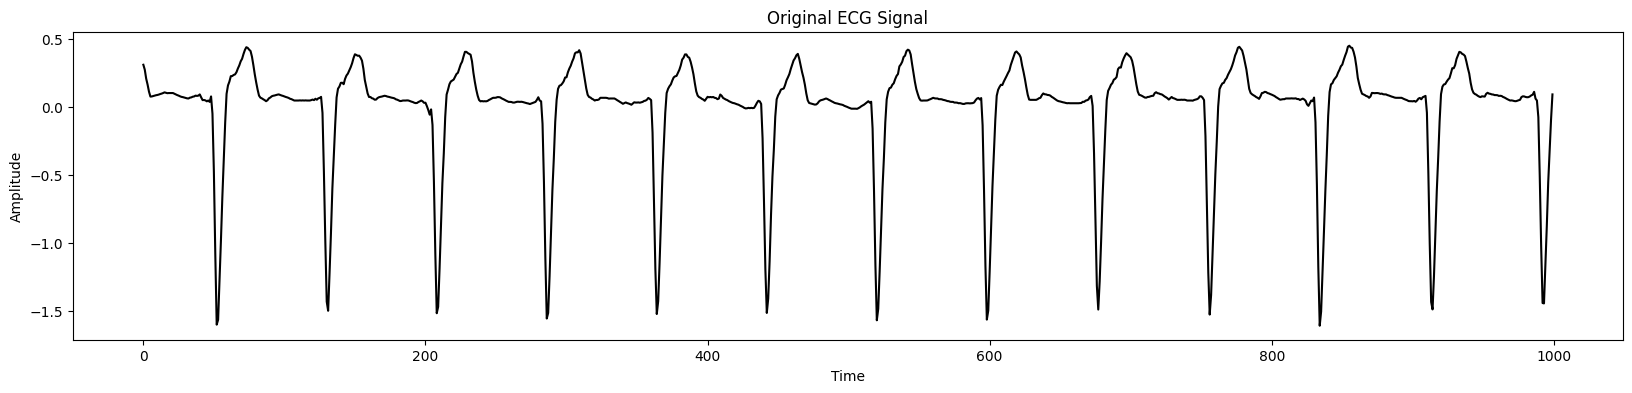

In [9]:
# Display the original input (ECG signal)
plt.figure(figsize=(20, 4))
num_channels = input_example.shape[1]
num_points = input_example.shape[2]
plt.plot(np.arange(num_points), input_example[0, :, :, 0].T, color='black')  # Transpose to match dimensions
plt.title('Original ECG Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()


In [10]:
# Shape of input_example: (1, 1, 1000, 1)
# preprocessed_input = load_image(sys.argv[1])
# x = np.transpose(input_example, (1, 0))                 # transpose matrix
# x = np.expand_dims(x, axis=(0, -1))                # Add another channel on left and right

classes = ['Conduction Disturbance', 'Hypertrophy', 'Myocardial Infarcation', 'Normal ECG', 'ST/T change']

predictions = model.predict(input_example)


print("Sample belongs to following classes:")
for i in range(5):
    if predictions[0][i] >= 0.5 :
        print(" * " + classes[i])

2024-04-16 07:31:54.116630: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2024-04-16 07:31:55.074483: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-16 07:31:55.918333: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 6s 6s/step
Sample belongs to following classes:
 * Conduction Disturbance
 * Myocardial Infarcation


In [11]:
input_example.shape

(1, 1, 1000, 1)

## New Trial

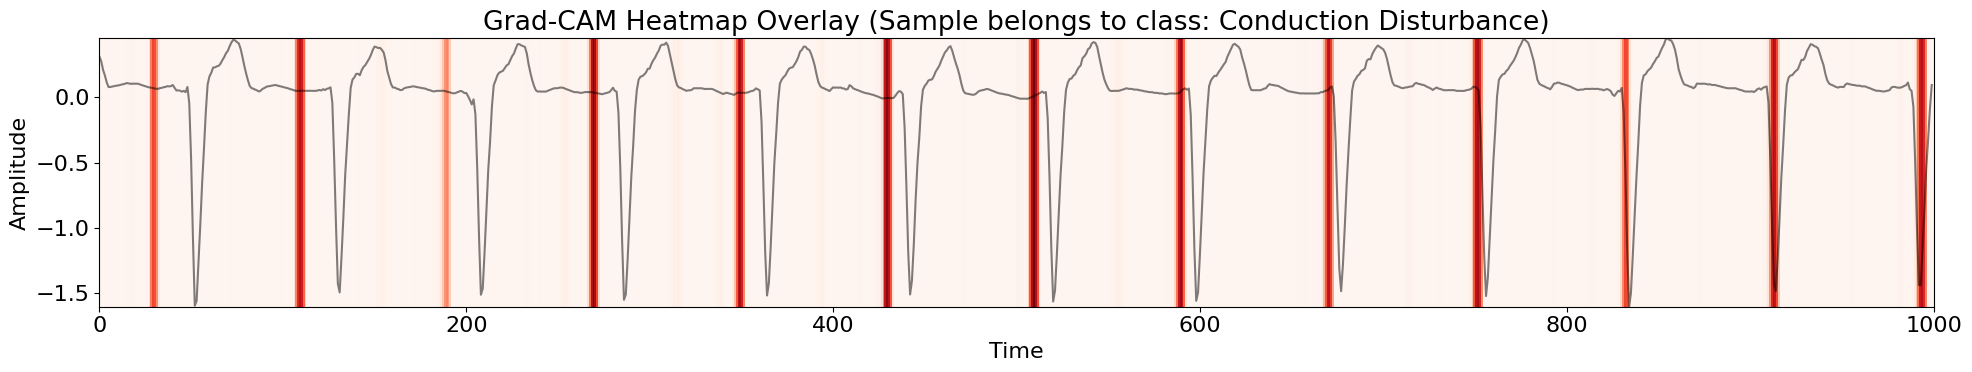

In [12]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# Assuming 'input_example' is your ECG input with shape (1, 1, 1000, 1)
num_points = 1000  # Set the number of points to 200

sample_classes_str = ', '.join([classes[i] for i, prob in enumerate(predictions[0]) if prob >= 0.5])

# Get the model's last convolutional layer and output layer
last_conv_layer = model.get_layer('conv2d_9')  
output_layer = model.get_layer('dense_2')  

# Create a model that maps the input to the activations of the last conv layer
heatmap_model = keras.models.Model([model.inputs], [last_conv_layer.output, output_layer.output])

# Get the gradients of the predicted class with respect to the activations of the last conv layer
with tf.GradientTape() as tape:
    conv_outputs, predictions = heatmap_model(input_example)
    class_output = predictions[:, np.argmax(predictions[0])]

# Get the gradients of the predicted class with respect to the last conv layer's output
grads = tape.gradient(class_output, conv_outputs)[0]

# Global average pooling to get the gradient-weighted activation map
pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

# Calculate the heatmap as the weighted sum of the activation maps
heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs[0]), axis=-1)

# Apply ReLU and normalization
heatmap = tf.nn.relu(heatmap)
heatmap /= tf.reduce_max(heatmap)

# Resize the heatmap to match the original input size
input_shape = input_example.shape[1:3]
heatmap_np = heatmap.numpy()
heatmap_resized = cv2.resize(heatmap_np, (input_shape[1], input_shape[0]))

# Convert the heatmap to RGB using matplotlib's 'Reds' colormap
heatmap_rgb = plt.cm.Reds(heatmap_resized)[:, :, :3]  # Use only the RGB channels

# Superimpose the heatmap on the original ECG signal with lighter alpha values
superimposed_img = heatmap_rgb * 0.5 + np.expand_dims(input_example[0, :, :, 0], axis=-1) * 0.5  # Adjust alpha values (e.g., 0.5)
superimposed_img = np.clip(superimposed_img, 0, 1)  # Clip values to the valid range [0, 1]

# Convert the original ECG signal to RGB
original_ecg_rgb = plt.cm.gray(input_example[0, :, :, 0])[:, :, :3]


# Plot the figures with RGB colors
plt.rc('font', size=16) 
plt.figure(figsize=(20, 4))  # Increase the figure size for better visualization

# Original ECG Signal plot with Superimposed Image (showing only the first 200 points)
plt.plot(np.arange(num_points), input_example[0, 0, :num_points, 0], color='black', alpha=0.5)  # Light gray color with transparency
heatmap_im = plt.imshow(heatmap_rgb[:, :num_points, :], extent=[0, num_points, np.min(input_example), np.max(input_example)], aspect='auto', interpolation='nearest')
plt.imshow(heatmap_rgb[:, :num_points, :], extent=[0, num_points, np.min(input_example), np.max(input_example)], aspect='auto', interpolation='nearest')
plt.title(f'Grad-CAM Heatmap Overlay (Sample belongs to class: {sample_classes_str})')
# plt.title('Grad-CAM Heatmap Overlay (First 200 Points)')
plt.xlabel('Time')
plt.ylabel('Amplitude')

# Add colorbar for the heatmap
# cbar = plt.colorbar(heatmap_im, orientation='vertical')
# cbar.set_label('Activation', rotation=270, labelpad=15)

plt.tight_layout(h_pad=1.5)
plt.show()


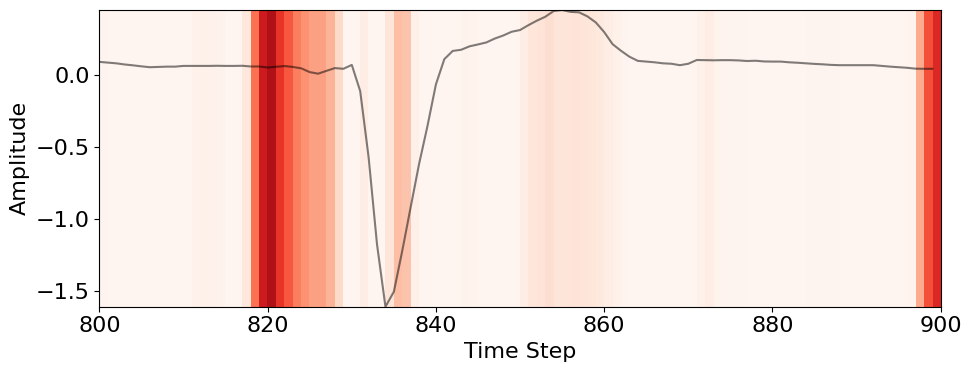

In [39]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Assuming 'input_example' is your ECG input with shape (1, 1, 1000, 1)
num_points = 1000  # Set the number of points to 200
start_point = 800
end_point = 900

sample_classes_str = ', '.join([classes[i] for i, prob in enumerate(predictions[0]) if prob >= 0.5])

# Get the model's last convolutional layer and output layer
last_conv_layer = model.get_layer('conv2d_9')  
output_layer = model.get_layer('dense_2')  

# Create a model that maps the input to the activations of the last conv layer
heatmap_model = keras.models.Model([model.inputs], [last_conv_layer.output, output_layer.output])

# Get the gradients of the predicted class with respect to the activations of the last conv layer
with tf.GradientTape() as tape:
    conv_outputs, predictions = heatmap_model(input_example)
    class_output = predictions[:, np.argmax(predictions[0])]

# Get the gradients of the predicted class with respect to the last conv layer's output
grads = tape.gradient(class_output, conv_outputs)[0]

# Global average pooling to get the gradient-weighted activation map
pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

# Calculate the heatmap as the weighted sum of the activation maps
heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs[0]), axis=-1)

# Apply ReLU and normalization
heatmap = tf.nn.relu(heatmap)
heatmap /= tf.reduce_max(heatmap)

# Resize the heatmap to match the original input size
input_shape = input_example.shape[1:3]
heatmap_np = heatmap.numpy()
heatmap_resized = cv2.resize(heatmap_np, (input_shape[1], input_shape[0]))

# Define a custom red colormap
# red_cmap = mcolors.ListedColormap(['#ff0000', '#ff3300', '#ff6600', '#ff9900', '#ffcc00', '#ffff00'])

# Convert the heatmap to RGB using the custom red colormap
heatmap_rgb = plt.cm.Reds(heatmap_resized)[:, :, :3]  # Use only the RGB channels

# Superimpose the heatmap on the original ECG signal with lighter alpha values
superimposed_img = heatmap_rgb * 0.5 + np.expand_dims(input_example[0, :, :, 0], axis=-1) * 0.5  # Adjust alpha values (e.g., 0.5)
superimposed_img = np.clip(superimposed_img, 0, 1)  # Clip values to the valid range [0, 1]

# Convert the original ECG signal to RGB
original_ecg_rgb = plt.cm.gray(input_example[0, :, :, 0])[:, :, :3]

# Plot the figures with RGB colors
plt.figure(figsize=(10, 4))  # Increase the figure size for better visualization

# Original ECG Signal plot with Superimposed Image (showing only the first 200 points)
plt.plot(np.arange(start_point, end_point), input_example[0, 0, start_point:end_point, 0], color='black', alpha=0.5)  # Light gray color with transparency
heatmap_im = plt.imshow(heatmap_rgb[:, start_point:end_point, :], extent=[start_point, end_point, np.min(input_example), np.max(input_example)], aspect='auto', interpolation='nearest')
plt.imshow(heatmap_rgb[:, start_point:end_point, :], extent=[start_point, end_point, np.min(input_example), np.max(input_example)], aspect='auto', interpolation='nearest')
# plt.title(f'Grad-CAM Heatmap Overlay (Sample belongs to class: {sample_classes_str})')
# plt.title('Grad-CAM Heatmap Overlay (First 200 Points)')
plt.xlabel('Time Step')
plt.ylabel('Amplitude')

# Add colorbar for the heatmap
# cbar = plt.colorbar(heatmap_im, orientation='vertical')
# cbar.set_label('Activation', rotation=270, labelpad=15)

plt.tight_layout(h_pad=1.5)
plt.show()


heatmap_resized: ((1, 1000))
non_zero_segments: ([(5, 0.007023533806204796), (9, 0.19401824474334717), (10, 0.2719195485115051), (15, 0.19290032982826233), (17, 0.6966837048530579), (18, 0.47706806659698486), (21, 0.049133315682411194), (22, 0.03574483096599579), (23, 0.017966674640774727), (24, 0.0882953628897667), (25, 0.019203439354896545), (32, 0.008153404109179974), (35, 0.10341621935367584), (36, 0.09063909202814102), (46, 4.023804933694919e-07), (48, 0.28812000155448914), (49, 0.7309573888778687)])
Top 5 gradient segments: [49, 17, 18, 48, 10]


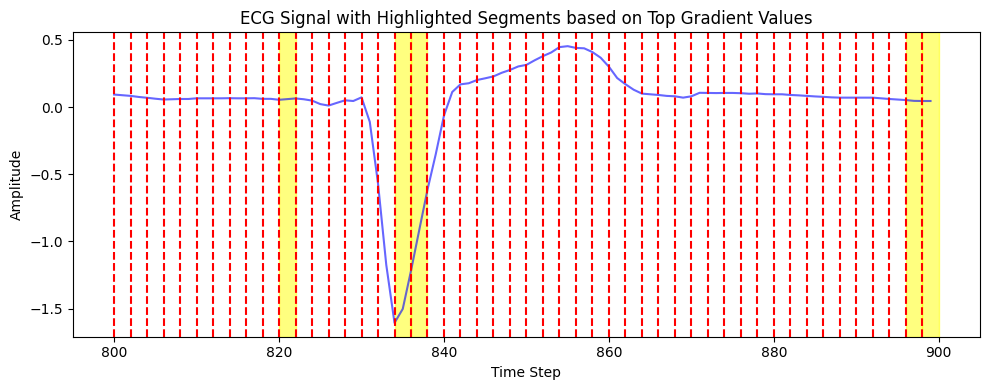

In [31]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# Define function to compute Grad-CAM gradients and resized heatmap for the whole ECG
def compute_grad_cam_gradients(input_data, model):
    # Get the model's last convolutional layer and output layer
    last_conv_layer = model.get_layer('conv2d_9')  
    output_layer = model.get_layer('dense_2')  
    
    # Create a model that maps the input to the activations of the last conv layer
    heatmap_model = keras.models.Model([model.inputs], [last_conv_layer.output, output_layer.output])

    # Get the gradients of the predicted class with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        conv_outputs, predictions = heatmap_model(input_data)
        class_output = predictions[:, np.argmax(predictions[0])]

    # Get the gradients of the predicted class with respect to the last conv layer's output
    grads = tape.gradient(class_output, conv_outputs)[0]

    # Global average pooling to get the gradient-weighted activation map
    pooled_grads = tf.reduce_max(grads, axis=(0, 1))

    # Calculate the heatmap as the weighted sum of the activation maps
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs[0]), axis=-1)

    # Apply ReLU and normalization
    heatmap = tf.nn.relu(heatmap)
    heatmap /= tf.reduce_max(heatmap)

    # Resize the heatmap to match the original input size
    input_shape = input_data.shape[1:3]
    heatmap_np = heatmap.numpy()
    heatmap_resized = cv2.resize(heatmap_np, (input_shape[1], input_shape[0]))
    print(f"heatmap_resized: ({heatmap_resized.shape})")

    return heatmap_resized


# Assuming 'input_example' is your ECG input with shape (1, 1, 1000, 1)
num_points = 1000  # Set the number of points to 200
start_point = 800
end_point = 900
input_example2 = np.reshape(input_example, (1000, 1))
instance_ecg = input_example2[start_point:end_point]

# Compute Grad-CAM gradients and resized heatmap for the whole ECG
heatmap_resized = compute_grad_cam_gradients(input_example, model)
heatmap_resized_reshaped = heatmap_resized.reshape(1000,)

# Divide the ECG data into segments based on the heatmap
num_segments = 50
segment_size = len(input_example[0, 0, start_point:end_point, 0]) // num_segments

# Use max Grad-CAM gradient for each segment
segment_grad_cam_gradients = np.zeros(num_segments)
for i in range(num_segments):
    segment_start = i * segment_size + start_point
    segment_end = (i + 1) * segment_size + start_point
    # Check if the segment is within the valid range
    # print(f"segment_end: ({segment_end})")
    # print(f"end_point: ({end_point})")
    if segment_start < end_point:
        segment_grad_cam_gradients[i] = np.max(heatmap_resized_reshaped[segment_start:segment_end])


# Filter out segments with zero size
non_zero_segments = [(idx, val) for idx, val in enumerate(segment_grad_cam_gradients) if val != 0]
print(f"non_zero_segments: ({non_zero_segments})")

# Sort the segments based on their Grad-CAM gradients
sorted_segments = sorted(non_zero_segments, key=lambda x: x[1], reverse=True)
top_5_indices = [idx for idx, _ in sorted_segments[:5]]
print("Top 5 gradient segments:", top_5_indices)



# Plot the ECG signal with highlighted segments based on top gradient values
plt.figure(figsize=(10, 4))
plt.plot(np.arange(start_point, end_point), input_example[0, 0, start_point:end_point, 0], color='blue', alpha=0.6)  # Original ECG signal
# Plot vertical dashed blue lines for each segment
for i in range(num_segments):
    segment_start = i * segment_size + start_point
    plt.axvline(x=segment_start, color='red', linestyle='--')

top_n = min(5, len(sorted_segments))
for i, (segment_idx, _) in enumerate(sorted_segments[:top_n]):
    segment_start = segment_idx * segment_size + start_point
    segment_end = (segment_idx + 1) * segment_size + start_point
    plt.axvspan(segment_start, segment_end, color='yellow', alpha=0.5)  # Highlight segment
plt.xlabel('Time Step')
plt.ylabel('Amplitude')
plt.title('ECG Signal with Highlighted Segments based on Top Gradient Values')
plt.tight_layout()
plt.show()


## Normal ECG

In [ ]:
# import cv2
# import numpy as np
# import tensorflow as tf
# from tensorflow import keras
# import matplotlib.pyplot as plt

# # Assuming 'input_example' is your ECG input with shape (1, 1, 1000, 1)
# num_points = input_example.shape[2]

# # Get the model's last convolutional layer and output layer
# last_conv_layer = model.get_layer('conv2d_19')  
# output_layer = model.get_layer('dense_5')  

# # Create a model that maps the input to the activations of the last conv layer
# heatmap_model = keras.models.Model([model.inputs], [last_conv_layer.output, output_layer.output])

# # Get the gradients of the predicted class with respect to the activations of the last conv layer
# with tf.GradientTape() as tape:
#     conv_outputs, predictions = heatmap_model(input_example)
#     class_output = predictions[:, np.argmax(predictions[0])]

# # Get the gradients of the predicted class with respect to the last conv layer's output
# grads = tape.gradient(class_output, conv_outputs)[0]

# # Global average pooling to get the gradient-weighted activation map
# pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

# # Calculate the heatmap as the weighted sum of the activation maps
# heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs[0]), axis=-1)

# # Apply ReLU and normalization
# heatmap = tf.nn.relu(heatmap)
# heatmap /= tf.reduce_max(heatmap)

# # Resize the heatmap to match the original input size
# input_shape = input_example.shape[1:3]
# heatmap_np = heatmap.numpy()
# heatmap_resized = cv2.resize(heatmap_np, (input_shape[1], input_shape[0]))

# # Convert the heatmap to RGB using matplotlib's 'viridis' colormap
# heatmap_rgb = plt.cm.viridis(heatmap_resized)[:, :, :3]  # Use only the RGB channels

# # Superimpose the heatmap on the original ECG signal
# superimposed_img = heatmap_rgb * 0.7 + np.expand_dims(input_example[0, :, :, 0], axis=-1) * 0.3  # Adjust alpha values
# superimposed_img = np.clip(superimposed_img, 0, 1)  # Clip values to the valid range [0, 1]

# # Convert the original ECG signal to RGB
# original_ecg_rgb = plt.cm.gray(input_example[0, :, :, 0])[:, :, :3]

# # Plot the figures with RGB colors
# plt.figure(figsize=(12, 8))

# plt.subplot(4, 1, 1)
# plt.plot(np.arange(num_points), input_example[0, :, :, 0].T, color='black')  # Original ECG plot
# plt.title('Original ECG Signal')
# plt.xlabel('Time')
# plt.ylabel('Amplitude')
# plt.xlim(0, num_points)  # Set x-axis limits to start from 0
# plt.ylim(np.min(input_example), np.max(input_example))  # Set y-axis limits

# # Original ECG Signal plot
# plt.subplot(4, 1, 2)
# plt.imshow(original_ecg_rgb, extent=[0, num_points, np.min(input_example), np.max(input_example)], aspect='auto')
# plt.title('Original ECG Signal')
# plt.xlabel('Time')
# plt.ylabel('Amplitude')

# plt.subplot(4, 1, 3)
# plt.imshow(heatmap_rgb, extent=[0, num_points, np.min(input_example), np.max(input_example)], aspect='auto', interpolation='nearest')
# plt.title('Grad-CAM Heatmap Overlay')
# plt.xlabel('Time')
# plt.ylabel('Amplitude')

# plt.subplot(4, 1, 4)
# plt.imshow(superimposed_img, extent=[0, num_points, np.min(input_example), np.max(input_example)], aspect='auto', interpolation='nearest')
# plt.title('Superimposed Image')
# plt.xlabel('Time')
# plt.ylabel('Amplitude')

# plt.tight_layout(h_pad=1.5)
# plt.show()


The second image plotting (Original ECG Signal plot as an image) uses plt.imshow to display the ECG signal as an image, where the color intensity represents the amplitude of the signal. In this case, the grayscale colormap (plt.cm.gray) is used to convert the single-channel ECG signal to a grayscale image. Darker regions indicate lower amplitudes, while lighter regions indicate higher amplitudes.

## MI

Text(0, 0.5, 'Amplitude')

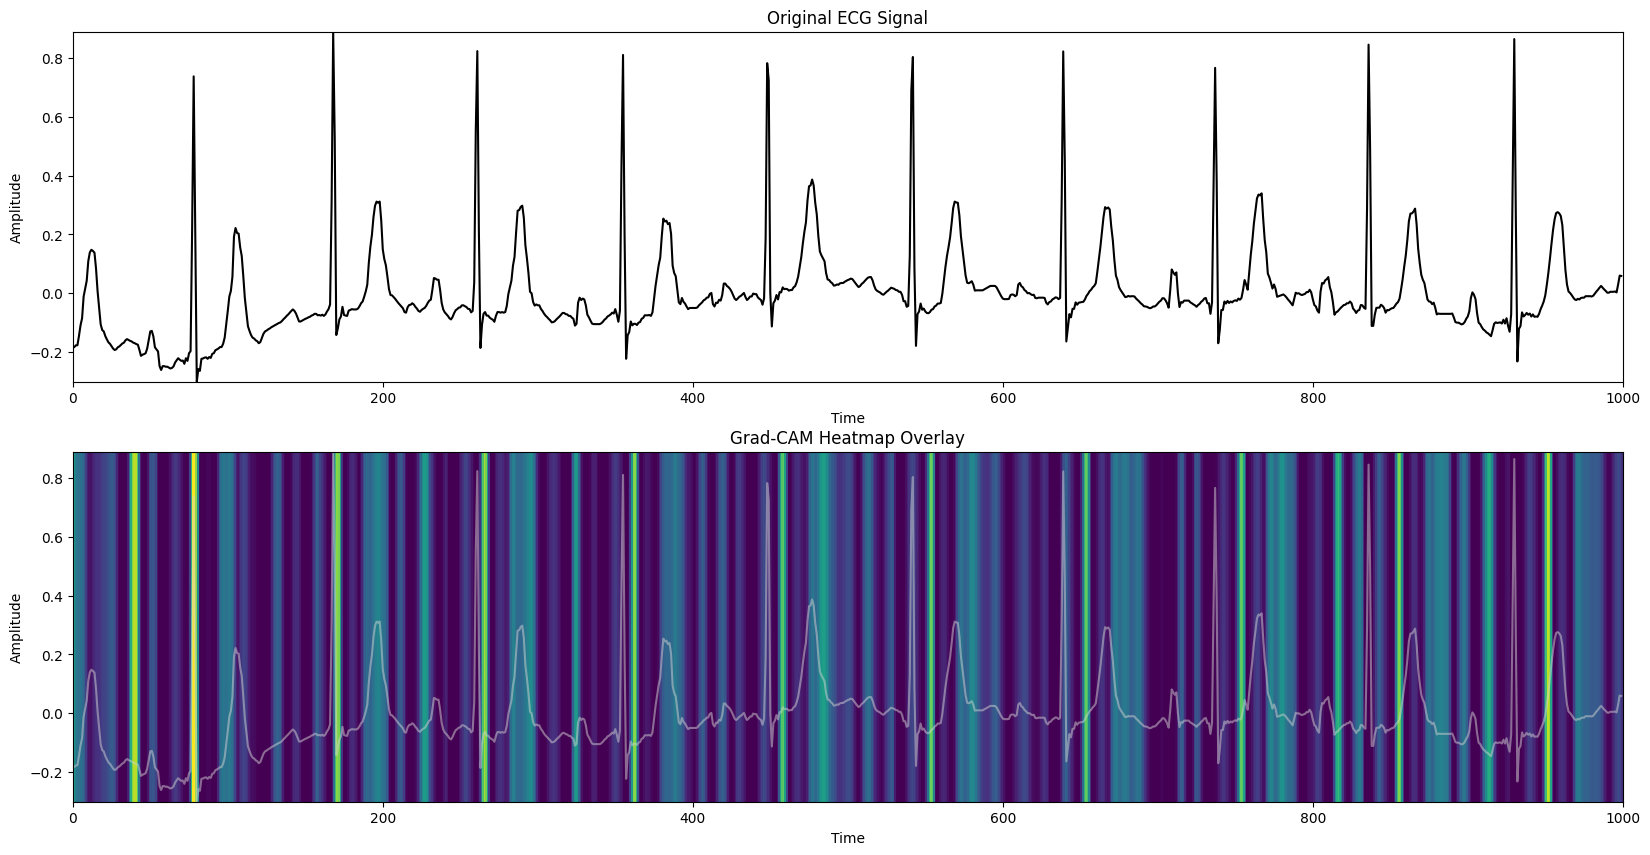

In [18]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# Assuming 'input_example' is your ECG input with shape (1, 1, 1000, 1)
num_points = 1000  # Set the number of points to 200

# Get the model's last convolutional layer and output layer
last_conv_layer = model.get_layer('conv2d_19')  
output_layer = model.get_layer('dense_5')  

# Create a model that maps the input to the activations of the last conv layer
heatmap_model = keras.models.Model([model.inputs], [last_conv_layer.output, output_layer.output])

# Get the gradients of the predicted class with respect to the activations of the last conv layer
with tf.GradientTape() as tape:
    conv_outputs, predictions = heatmap_model(input_example)
    class_output = predictions[:, np.argmax(predictions[0])]

# Get the gradients of the predicted class with respect to the last conv layer's output
grads = tape.gradient(class_output, conv_outputs)[0]

# Global average pooling to get the gradient-weighted activation map
pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

# Calculate the heatmap as the weighted sum of the activation maps
heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs[0]), axis=-1)

# Apply ReLU and normalization
heatmap = tf.nn.relu(heatmap)
heatmap /= tf.reduce_max(heatmap)

# Resize the heatmap to match the original input size
input_shape = input_example.shape[1:3]
heatmap_np = heatmap.numpy()
heatmap_resized = cv2.resize(heatmap_np, (input_shape[1], input_shape[0]))

# Convert the heatmap to RGB using matplotlib's 'viridis' colormap
heatmap_rgb = plt.cm.viridis(heatmap_resized)[:, :, :3]  # Use only the RGB channels

# Superimpose the heatmap on the original ECG signal with lighter alpha values
superimposed_img = heatmap_rgb * 0.5 + np.expand_dims(input_example[0, :, :, 0], axis=-1) * 0.5  # Adjust alpha values (e.g., 0.5)
superimposed_img = np.clip(superimposed_img, 0, 1)  # Clip values to the valid range [0, 1]

# Convert the original ECG signal to RGB
original_ecg_rgb = plt.cm.gray(input_example[0, :, :, 0])[:, :, :3]


# Plot the figures with RGB colors
plt.figure(figsize=(20, 10))  # Increase the figure size for better visualization

# Original ECG Signal plot (showing only the first 200 points)
plt.subplot(2, 1, 1)
plt.plot(np.arange(num_points), input_example[0, 0, :num_points, 0], color='black')  # Light gray color
plt.title('Original ECG Signal')
# plt.title('Original ECG Signal (First 200 Points)')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.xlim(0, num_points)
plt.ylim(np.min(input_example), np.max(input_example))

# # Original ECG Signal plot with RGB colors (showing only the first 200 points)
# plt.subplot(4, 1, 2)
# plt.plot(np.arange(num_points), input_example[0, 0, :num_points, 0], color='lightgray', alpha=0.5)  # Light gray color with transparency
# plt.imshow(original_ecg_rgb[:, :num_points, :], extent=[0, num_points, np.min(input_example), np.max(input_example)], aspect='auto')
# plt.title('Original ECG Signal')
# # plt.title('Original ECG Signal (First 200 Points)')
# plt.xlabel('Time')
# plt.ylabel('Amplitude')

# Original ECG Signal plot with Heatmap Overlay (showing only the first 200 points)
plt.subplot(2, 1, 2)
plt.plot(np.arange(num_points), input_example[0, 0, :num_points, 0], color='lightgray', alpha=0.5)  # Light gray color with transparency
plt.imshow(heatmap_rgb[:, :num_points, :], extent=[0, num_points, np.min(input_example), np.max(input_example)], aspect='auto', interpolation='nearest')
plt.title('Grad-CAM Heatmap Overlay')
# plt.title('Grad-CAM Heatmap Overlay (First 200 Points)')
plt.xlabel('Time')
plt.ylabel('Amplitude')

# # Original ECG Signal plot with Superimposed Image (showing only the first 200 points)
# plt.subplot(4, 1, 4)
# plt.plot(np.arange(num_points), input_example[0, 0, :num_points, 0], color='lightgray', alpha=0.5)  # Light gray color with transparency
# plt.imshow(superimposed_img[:, :num_points, :], extent=[0, num_points, np.min(input_example), np.max(input_example)], aspect='auto', interpolation='nearest')
# plt.title('Superimposed Image')
# # plt.title('Superimposed Image (First 200 Points)')
# plt.xlabel('Time')
# plt.ylabel('Amplitude')

# plt.tight_layout(h_pad=1.5)
# plt.show()

In [21]:
input_example.shape

(1, 1, 1000, 1)

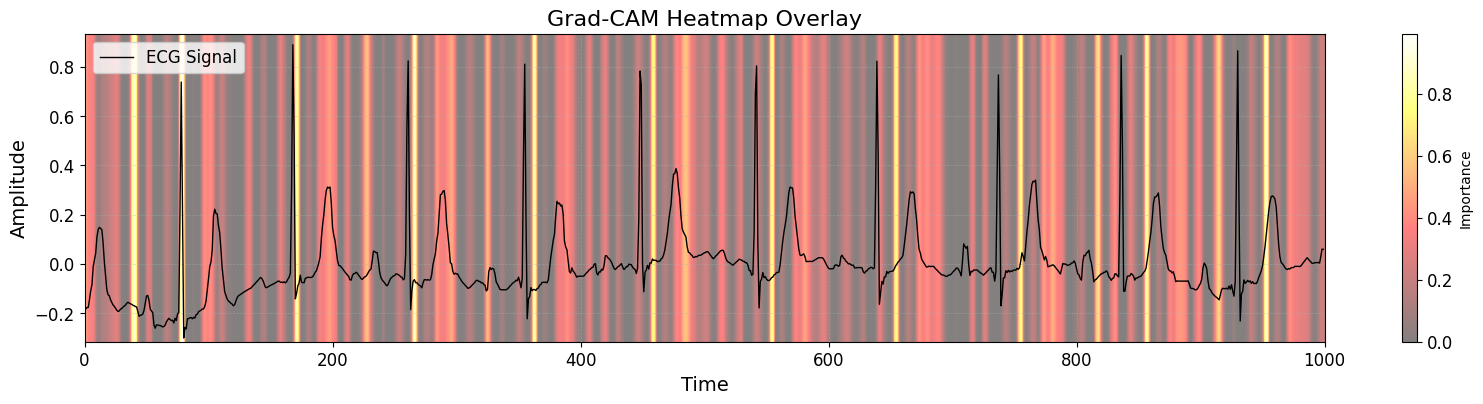

In [26]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

def grad_cam(layer_name, data, model):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_output, preds = grad_model(data)
        pred_index = tf.argmax(preds[0])
        class_output = preds[:, pred_index]

    grads = tape.gradient(class_output, conv_output)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
    heatmap = tf.nn.relu(heatmap)
    heatmap /= tf.reduce_max(heatmap)
    
    return heatmap.numpy()

# Plot the heatmap overlaying on the original ECG signal
plt.figure(figsize=(20, 4))

# Plot the original ECG signal
plt.plot(np.arange(input_example.shape[2]), input_example[0, 0, :, 0], color='black', linewidth=1, label='ECG Signal')

# Reshape heatmap_resized to (1000,)
heatmap_resized = np.squeeze(heatmap_resized)

# Then plot the heatmap
plt.imshow(np.expand_dims(heatmap_resized, axis=0), cmap='hot', aspect="auto",
           extent=[0, 1000, input_example.min()*1.05, input_example.max()*1.05], alpha=0.5)

# Add colorbar for the heatmap
cbar = plt.colorbar(label='Importance')
cbar.ax.tick_params(labelsize=12)  # Adjust colorbar font size

# Add labels and title
plt.xlabel('Time', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)
plt.title('Grad-CAM Heatmap Overlay', fontsize=16)

# Add grid lines
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

# Adjust legend
plt.legend(fontsize=12)

# Adjust ticks font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()



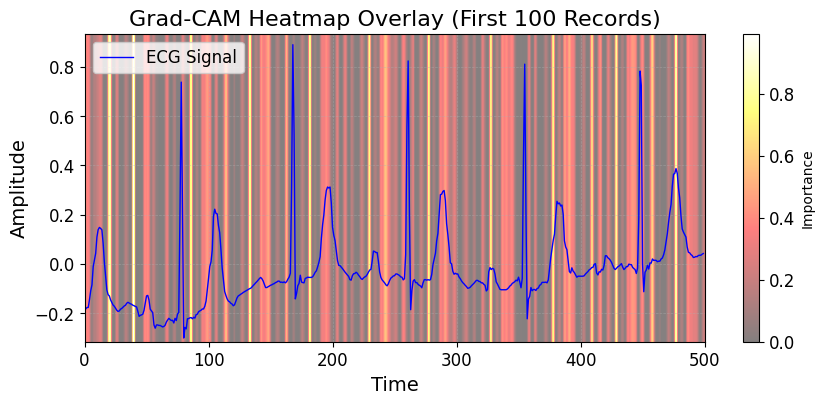

In [25]:
# Plot the heatmap overlaying on the original ECG signal
plt.figure(figsize=(10, 4))

# Plot the original ECG signal
plt.plot(np.arange(500), input_example[0, 0, :500, 0], color='blue', linewidth=1, label='ECG Signal')

# Reshape heatmap_resized to (1000,)
heatmap_resized = np.squeeze(heatmap_resized)

# Overlay the heatmap with transparency
plt.imshow(np.expand_dims(heatmap_resized, axis=0), cmap='hot', aspect="auto",
           extent=[0, 500, input_example.min()*1.05, input_example.max()*1.05], alpha=0.5)

# Add colorbar for the heatmap
cbar = plt.colorbar(label='Importance')
cbar.ax.tick_params(labelsize=12)  # Adjust colorbar font size

# Add labels and title
plt.xlabel('Time', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)
plt.title('Grad-CAM Heatmap Overlay (First 100 Records)', fontsize=16)

# Add grid lines
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

# Adjust legend
plt.legend(fontsize=12)

# Adjust ticks font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()


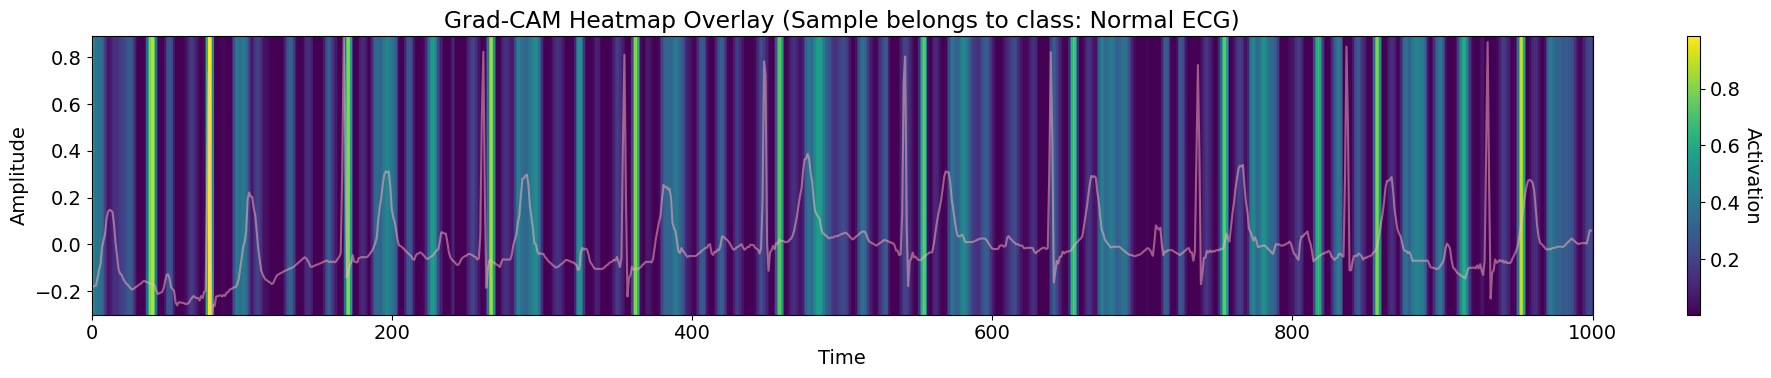

In [46]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# Assuming 'input_example' is your ECG input with shape (1, 1, 1000, 1)
num_points = 1000  # Set the number of points to 200

sample_classes_str = ', '.join([classes[i] for i, prob in enumerate(predictions[0]) if prob >= 0.5])

# Get the model's last convolutional layer and output layer
last_conv_layer = model.get_layer('conv2d_19')  
output_layer = model.get_layer('dense_5')  

# Create a model that maps the input to the activations of the last conv layer
heatmap_model = keras.models.Model([model.inputs], [last_conv_layer.output, output_layer.output])

# Get the gradients of the predicted class with respect to the activations of the last conv layer
with tf.GradientTape() as tape:
    conv_outputs, predictions = heatmap_model(input_example)
    class_output = predictions[:, np.argmax(predictions[0])]

# Get the gradients of the predicted class with respect to the last conv layer's output
grads = tape.gradient(class_output, conv_outputs)[0]

# Global average pooling to get the gradient-weighted activation map
pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

# Calculate the heatmap as the weighted sum of the activation maps
heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs[0]), axis=-1)

# Apply ReLU and normalization
heatmap = tf.nn.relu(heatmap)
heatmap /= tf.reduce_max(heatmap)

# Resize the heatmap to match the original input size
input_shape = input_example.shape[1:3]
heatmap_np = heatmap.numpy()
heatmap_resized = cv2.resize(heatmap_np, (input_shape[1], input_shape[0]))

# Convert the heatmap to RGB using matplotlib's 'viridis' colormap
heatmap_rgb = plt.cm.viridis(heatmap_resized)[:, :, :3]  # Use only the RGB channels

# Superimpose the heatmap on the original ECG signal with lighter alpha values
superimposed_img = heatmap_rgb * 0.5 + np.expand_dims(input_example[0, :, :, 0], axis=-1) * 0.5  # Adjust alpha values (e.g., 0.5)
superimposed_img = np.clip(superimposed_img, 0, 1)  # Clip values to the valid range [0, 1]

# Convert the original ECG signal to RGB
original_ecg_rgb = plt.cm.gray(input_example[0, :, :, 0])[:, :, :3]


# Plot the figures with RGB colors
plt.figure(figsize=(20, 4))  # Increase the figure size for better visualization

# Original ECG Signal plot with Superimposed Image (showing only the first 200 points)
plt.plot(np.arange(num_points), input_example[0, 0, :num_points, 0], color='lightpink', alpha=0.5)  # Light gray color with transparency
heatmap_im = plt.imshow(heatmap_rgb[:, :num_points, :], extent=[0, num_points, np.min(input_example), np.max(input_example)], aspect='auto', interpolation='nearest')
plt.imshow(heatmap_rgb[:, :num_points, :], extent=[0, num_points, np.min(input_example), np.max(input_example)], aspect='auto', interpolation='nearest')
plt.title(f'Grad-CAM Heatmap Overlay (Sample belongs to class: {sample_classes_str})')
# plt.title('Grad-CAM Heatmap Overlay (First 200 Points)')
plt.xlabel('Time')
plt.ylabel('Amplitude')

# Add colorbar for the heatmap
cbar = plt.colorbar(heatmap_im, orientation='vertical')
cbar.set_label('Activation', rotation=270, labelpad=15)

plt.tight_layout(h_pad=1.5)
plt.show()